# Домашнее задание. Классификация изображений

В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. 

In [20]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data.sampler import WeightedRandomSampler, SubsetRandomSampler
from torchvision import datasets, transforms

from collections import Counter
from pathlib import Path
import pickle
from PIL import Image
from skimage import io
from tqdm import tqdm, tqdm_notebook

from sklearn.preprocessing import LabelEncoder

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [21]:
torch.cuda.is_available()

True

Загружаем датасет

Делаем код воспроизводимым

In [22]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

Получаем список путей train_val_files, test_files

In [23]:
RESCALE_SIZE = 224
BATCH_SIZE = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
N_CORES = 2

In [24]:
TRAIN_DIR = Path('../input/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('../input/journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
train_labels = [path.parent.name for path in train_val_files]

Аугментация, предобработка

In [25]:
augmentations = transforms.RandomChoice([
    transforms.Compose([
        transforms.Resize(size=300, max_size=301),
        transforms.CenterCrop(size=300),
        transforms.RandomCrop(250)
    ]),
    transforms.RandomRotation(degrees=(-25, 25)),
    transforms.RandomHorizontalFlip(p=1),
])
train_transforms = transforms.Compose([
    augmentations,
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
])
val_transforms = transforms.Compose([
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
])

Формируем train_dataset, val_dataset

In [26]:
train_dataset_raw = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)
val_dataset_raw = datasets.ImageFolder(root=TRAIN_DIR, transform=val_transforms)

In [27]:
VAL_SIZE = 0.2

num_train = len(train_dataset_raw)
indices = list(range(num_train))
split = int(np.floor(VAL_SIZE * num_train))

np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

In [28]:
train_dataset = torch.utils.data.Subset(dataset=train_dataset_raw, indices=train_idx)
val_dataset = torch.utils.data.Subset(dataset=val_dataset_raw, indices=valid_idx)

In [29]:
len(train_dataset), len(val_dataset)

(16747, 4186)

Сбалансируем классы в train_dataset

In [30]:
# у класса Subset нет аттрибьюта targets
# подсчитываем, сколько экземпляров каждого класса в train_dataset
class_count = Counter(train_dataset_raw.targets[i] for i in train_idx) 

class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(train_dataset) # список из нулей длины len(train_dataset)
for i, (data, label) in enumerate(tqdm(train_dataset)):
    class_weight = class_weights[label]
    sample_weights[i] = class_weight

N = max(class_count.values()) * len(class_count)  # fit to max
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)

100%|██████████| 16747/16747 [03:27<00:00, 80.78it/s]


Dataloaders

In [31]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=N_CORES)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=N_CORES)

Теперь классы сбалансированны (запустить чтобы проверить):

In [32]:
# count = Counter()
# for data, labels in tqdm(train_loader):
#     count += Counter(labels.tolist())
# print(sum(count.values()), count)

In [33]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

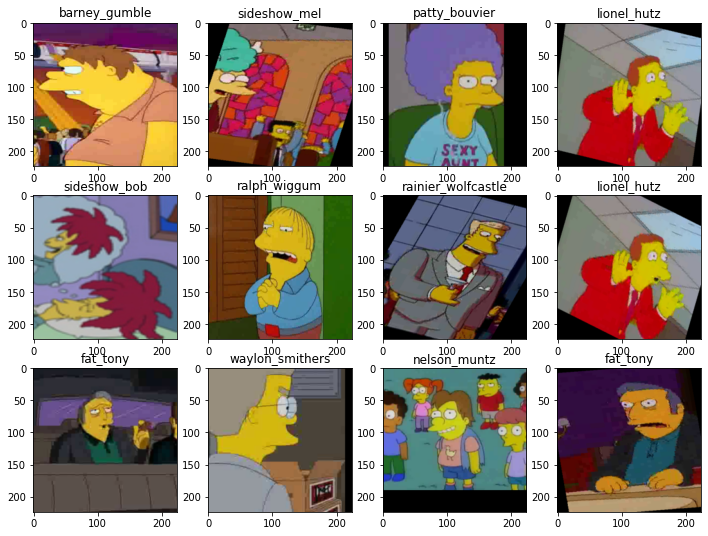

In [34]:
axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 9))[1]
data, labels = next(iter(train_loader))
for ax, d, l in zip(axes.flatten(), data, labels):
    imshow(d.data.cpu(), title=train_dataset_raw.classes[l], plt_ax=ax)

### Построение нейросети



Будем использовать baseline, но перепишем через Sequential

In [74]:
n_classes = len(np.unique(train_labels))
model = nn.Sequential(
    nn.Sequential(
        nn.Conv2d(3, 8, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(8, 16, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(64, 96, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Flatten(),
    nn.Linear(in_features=2400, out_features=n_classes),
).to(DEVICE)
print("We will classify {} classes".format(n_classes))
print(f"Model: {model}")

We will classify 42 classes
Model: Sequential(
  (0): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (5): Flatten(start_dim=1, end_dim=-1)
  (6):

In [75]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = F.softmax(outputs, dim=-1).argmax(-1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [76]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [77]:
def train(model, loss, optimizer, scheduler, epochs, batch_size):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, loss, optimizer, scheduler)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, loss)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [78]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = F.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Запустим обучение сети.

In [80]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

In [81]:
history = train(model=model, loss=loss, optimizer=optimizer, scheduler=scheduler, epochs=20, batch_size=BATCH_SIZE)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 1.854127895342929


epoch:   5%|▌         | 1/20 [08:15<2:36:47, 495.12s/it]


Epoch 001 train_loss: 1.8541     val_loss 1.6825 train_acc 0.5190 val_acc 0.5540
loss 0.7354143390427041


epoch:  10%|█         | 2/20 [16:27<2:27:58, 493.25s/it]


Epoch 002 train_loss: 0.7354     val_loss 1.1846 train_acc 0.8052 val_acc 0.6942
loss 0.5035733516995621


epoch:  15%|█▌        | 3/20 [24:42<2:20:01, 494.19s/it]


Epoch 003 train_loss: 0.5036     val_loss 1.0748 train_acc 0.8650 val_acc 0.7217
loss 0.3876168099991405


epoch:  20%|██        | 4/20 [32:48<2:10:57, 491.09s/it]


Epoch 004 train_loss: 0.3876     val_loss 1.0425 train_acc 0.8954 val_acc 0.7516
loss 0.33135774937498125


epoch:  25%|██▌       | 5/20 [40:52<2:02:07, 488.50s/it]


Epoch 005 train_loss: 0.3314     val_loss 0.9668 train_acc 0.9100 val_acc 0.7642
loss 0.2798120565853687


epoch:  30%|███       | 6/20 [48:57<1:53:41, 487.27s/it]


Epoch 006 train_loss: 0.2798     val_loss 0.9548 train_acc 0.9232 val_acc 0.7759
loss 0.25259367014624495


epoch:  35%|███▌      | 7/20 [57:00<1:45:16, 485.87s/it]


Epoch 007 train_loss: 0.2526     val_loss 0.8913 train_acc 0.9302 val_acc 0.7957
loss 0.22016653265366426


epoch:  40%|████      | 8/20 [1:05:00<1:36:49, 484.12s/it]


Epoch 008 train_loss: 0.2202     val_loss 0.9011 train_acc 0.9393 val_acc 0.7991
loss 0.16801257748553947


epoch:  45%|████▌     | 9/20 [1:13:03<1:28:41, 483.73s/it]


Epoch 009 train_loss: 0.1680     val_loss 0.7936 train_acc 0.9538 val_acc 0.8292
loss 0.1457421444551766


epoch:  50%|█████     | 10/20 [1:21:05<1:20:31, 483.11s/it]


Epoch 010 train_loss: 0.1457     val_loss 0.7985 train_acc 0.9599 val_acc 0.8294
loss 0.1401244985459408


epoch:  55%|█████▌    | 11/20 [1:29:08<1:12:28, 483.14s/it]


Epoch 011 train_loss: 0.1401     val_loss 0.8228 train_acc 0.9621 val_acc 0.8321
loss 0.13819999959652282


epoch:  60%|██████    | 12/20 [1:37:12<1:04:25, 483.24s/it]


Epoch 012 train_loss: 0.1382     val_loss 0.7953 train_acc 0.9631 val_acc 0.8342
loss 0.13169699536086008


epoch:  65%|██████▌   | 13/20 [1:45:21<56:36, 485.23s/it]  


Epoch 013 train_loss: 0.1317     val_loss 0.8193 train_acc 0.9641 val_acc 0.8323
loss 0.12579299186388343


epoch:  70%|███████   | 14/20 [1:53:33<48:43, 487.22s/it]


Epoch 014 train_loss: 0.1258     val_loss 0.8143 train_acc 0.9663 val_acc 0.8383


epoch:  70%|███████   | 14/20 [1:54:09<48:55, 489.23s/it]


KeyboardInterrupt: 

val_loss не меняется и начинает немного расти, перестанем обучать модель

In [82]:
path = Path('/kaggle/working/model_new.pth')

In [83]:
torch.save(model.state_dict(), path)

Построим кривые обучения

In [94]:
loss, acc, val_loss, val_acc = zip(*history)

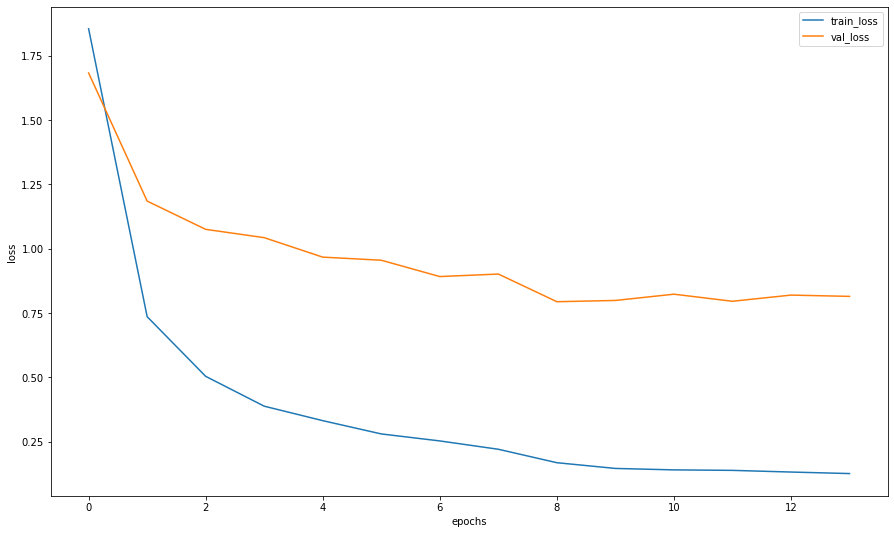

In [95]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

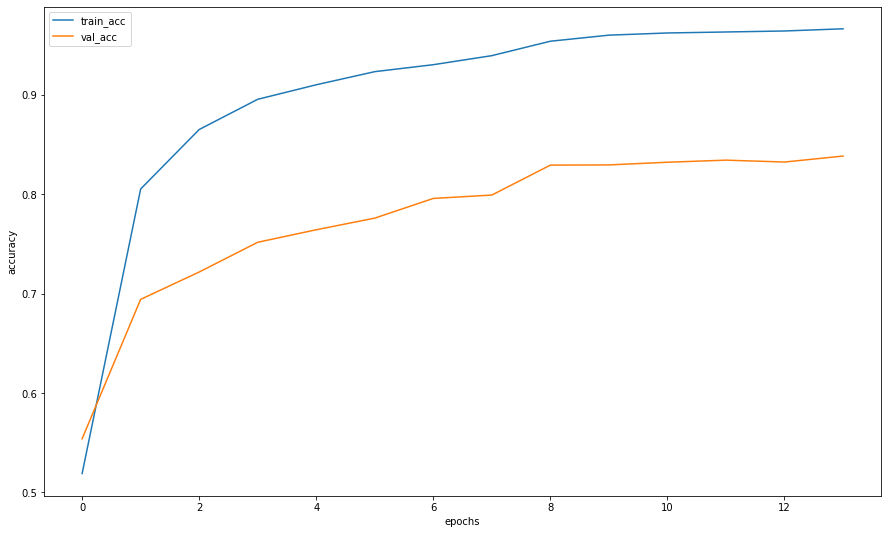

In [96]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

Предсказания на тесте:

In [98]:
class TestDataset(Dataset):
    def __init__(self, files):
        self.files = files

    def __getitem__(self, index):
        test_transforms = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
        ])
        img = Image.open(self.files[index]).convert('RGB')
        return test_transforms(img)
    
    def __len__(self):
        return len(self.files)

In [100]:
test_dataset = TestDataset(test_files)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)
probs = predict(model, test_loader)
preds = [train_dataset_raw.classes[i] for i in probs.argmax(axis=-1)]
test_filenames = [path.name for path in test_dataset.files]

Как мы видим, test_files идут не в том порядке, в котором нам надо их загрузить в .csv (а значит и предсказания тоже), нужна сортировка

In [172]:
answers = pd.DataFrame({
    "Id": test_filenames,
    "Expected": preds
})
answers.head(10)

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
5,img102.jpg,kent_brockman
6,img103.jpg,edna_krabappel
7,img104.jpg,chief_wiggum
8,img105.jpg,lisa_simpson
9,img106.jpg,kent_brockman


In [173]:
def get_number(name):
    return int(name[3:-4:])


answers['Num'] = answers['Id'].apply(get_number)
answers = answers.sort_values(by='Num', ignore_index=True).drop('Num', axis=1)
answers

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img2.jpg,mayor_quimby
3,img3.jpg,nelson_muntz
4,img4.jpg,lisa_simpson
...,...,...
986,img986.jpg,sideshow_bob
987,img987.jpg,nelson_muntz
988,img988.jpg,marge_simpson
989,img989.jpg,charles_montgomery_burns


In [174]:
answers.to_csv('simpson_classification.csv', index=False)

#### В итоге:

Качество на тесте: 0.93623